<a href="https://colab.research.google.com/github/Shamanth-KM/phi-demand-intent-lora/blob/main/notebooks/03_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03 - Fine-Tuning Phi-1.5 with LoRA: Model Setup, Training, Saving

In this notebook, we:
- Load the Phi-1.5 base model
- Apply Low-Rank Adaptation (LoRA)
- Fine-tune the model on the demand signal classification task
- Save the fine-tuned LoRA adapters

We fine-tune using sequence classification since our task is to predict demand intent categories from B2B sales notes.

In [1]:
# 📦 Force reinstall latest torch, torchvision, torchaudio
!pip install --upgrade torch torchvision torchaudio --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 766.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15

In [24]:
# Install necessary libraries
!pip install -q transformers datasets peft accelerate evaluate


## Set Random Seeds and Document Hyperparameters

To ensure reproducibility of our experiments, we set random seeds for Python, NumPy, and PyTorch.  
We also document key hyperparameter choices such as batch size, learning rate, number of epochs, and LoRA configuration parameters.

In [25]:
# Set random seeds
import random
import numpy as np
import torch

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

print(f"Random seeds set to {seed}")

Random seeds set to 42


## Load Tokenizer and Model for Sequence Classification

We load the Phi-1.5 tokenizer and the base model as a sequence classification model with 5 output labels.

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel

## Model Selection Justification: Phi-1.5

We selected the Phi-1.5 pre-trained model from the Hugging Face Hub for the following reasons:

- Architecture Suitability: Phi-1.5 is a decoder-only Transformer model designed for strong language modeling, reasoning, and structured understanding tasks. Our project involves classifying short, structured business sales notes, making a decoder-based model appropriate.

- Model Size (~1.3B Parameters): Phi-1.5 strikes a balance between model capacity and computational feasibility. Larger models (>7B) would be impractical for fine-tuning with limited resources, while smaller models (<300M) may lack sufficient generalization.

- Licensing and Trustworthiness: Phi-1.5 is released officially by Microsoft under an open and permissive license, ensuring ethical and legal usage for fine-tuning. The model card and repository were reviewed for integrity.

- Task Alignment: Given that sales notes are short, structured sentences that require contextual reasoning to classify, a model pre-trained on structured "textbook-quality" data like Phi-1.5 is especially suitable.

Thus, Phi-1.5 was chosen to balance performance, trust, licensing compliance, and feasibility for our fine-tuning assignment.


## Security Considerations: trust_remote_code=True

In order to properly load Phi-1.5, we use trust_remote_code=True to allow loading custom model architectures provided by the Hugging Face Hub.  
This setting can introduce security vulnerabilities if the source repository is malicious.  
To minimize risks, we verified that the source of the model (microsoft/phi-1_5) is an official Microsoft release and reviewed the repository structure for integrity.

In [27]:
# Loading the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Loading the base model
base_model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/phi-1_5",
    trust_remote_code=True,
    num_labels=5  # because we have 5 classes
)

# Set padding token id
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Tokenizer and base model are loaded!")


Some weights of PhiForSequenceClassification were not initialized from the model checkpoint at microsoft/phi-1_5 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer and base model are loaded!


## Apply LoRA Adaptation

We configure and apply LoRA to only a subset of model layers to save memory during training.

## Fine-Tuning Strategy and Justification

Given the size of the pre-trained Phi-1.5 model (~1.3B parameters) and the limited computational resources available, we adopted a **Parameter-Efficient Fine-Tuning (PEFT)** strategy using **Low-Rank Adaptation (LoRA)**.

- **Why not full fine-tuning?**
  - Full fine-tuning would require updating all model weights (~1.3B parameters), demanding extensive GPU memory (>100GB) and longer training times.
  - Our available GPU resources (e.g., Colab T4 or V100) could not accommodate full model fine-tuning efficiently.
  - With only ~5000 training examples, full fine-tuning also poses overfitting risks.

- **Why LoRA?**
  - LoRA trains only a small number of additional parameters (~1M) injected into key transformer layers.
  - It dramatically reduces GPU memory usage and computational requirements.
  - LoRA enables efficient fine-tuning while preserving most of the original model’s knowledge.

Thus, we applied LoRA to selected attention layers (q_proj and v_proj) to enable efficient, effective fine-tuning tailored to our task.


In [28]:
# Defining LoRA parameters
lora_config = LoraConfig(
    r=16,  # rank
    lora_alpha=32,  # scaling factor
    target_modules=["q_proj", "v_proj"],  # attention projections
    lora_dropout=0.05,  # using small dropout to prevent overfitting
    bias="none",  # we are not adapting biases
    task_type="SEQ_CLS"  # Sequence classification task
)

# Applying LoRA to the base model
base_model = get_peft_model(base_model, lora_config)

print("LoRA configuration is applied to the model")


LoRA configuration is applied to the model


In [29]:
# Let's look at which parts of the model are trainable now
base_model.print_trainable_parameters()

trainable params: 3,155,968 || all params: 1,316,528,128 || trainable%: 0.2397


In [30]:
# Let's re-upload the csv file needed
from google.colab import files
import pandas as pd
uploaded_file = files.upload()

# Get the file name
file_name = list(uploaded_file.keys())[0]

# Read the file to a pandas DataFrame
sales_notes = pd.read_csv(file_name)

# Check the first few rows
sales_notes.head()

Saving sales_notes_2000.csv to sales_notes_2000 (1).csv


,id,sales_note,label
0,1,Need emergency stock replenishment by friday.,Urgent Need
1,2,They are requesting a repeat of the previous o...,Repeat Order
2,3,Exploring samples for a new product line.,New Product Demand
3,4,Customized dimension required for part 780Y.,Custom Spec
4,5,inventory outage pls expedite shipping if poss...,Urgent Need


In [31]:
from datasets import Dataset
from transformers import AutoTokenizer

# Convert it into Hugging Face Dataset format
sales_hf = Dataset.from_pandas(sales_notes)
print(sales_hf)

# Loading the Phi-1.5 tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5", trust_remote_code=True)

# Phi-1.5's tokenizer does not have a pad_token defined by default.
'''
Decoder models (like GPT, Phi) usually don't need padding when generating text — but for training a classification model,
we do need padding to batch inputs of different lengths.
'''
tokenizer.pad_token = tokenizer.eos_token
base_model.config.pad_token_id = tokenizer.pad_token_id


# Let's define a tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["sales_note"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Applying tokenization
sales_tokenized = sales_hf.map(tokenize_function, batched=True)
sales_tokenized = sales_tokenized.remove_columns(["sales_note", "id"])

# Checking the structure after tokenization
print(sales_tokenized)

Dataset({
    features: ['id', 'sales_note', 'label'],
    num_rows: 2000
})


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})


In [32]:
# Encode labels

# Let's create a list of all unique labels
sales_labels = list(set(sales_notes["label"]))
sales_labels.sort()  # To keep consistent ordering

# Creating a mapping from label name to numeric ID
label_to_id = {label: idx for idx, label in enumerate(sales_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

print("Label mapping is created successfully")
print(label_to_id)

# Now let's map the text labels to numeric labels inside the tokenized dataset
def encode_labels(example):
    return {"labels": label_to_id[example["label"]]}

# Apply the label encoding
sales_tokenized = sales_tokenized.map(encode_labels)

# Removing the old 'label' column
sales_tokenized = sales_tokenized.remove_columns(["label"])

print("Labels are successfully encoded")
print(sales_tokenized)


Label mapping is created successfully
{'Custom Spec': 0, 'New Product Demand': 1, 'Repeat Order': 2, 'Stocking Issue': 3, 'Urgent Need': 4}


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Labels are successfully encoded
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 2000
})


In [33]:
# Let's split the dataset into training and validation sets
sales_split = sales_tokenized.train_test_split(test_size=0.4, seed=42)

train_sales = sales_split["train"]
val_sales = sales_split["test"]

print(f"\nDataset is split. Training size: {len(train_sales)}, Validation size: {len(val_sales)}")


Dataset is split. Training size: 1200, Validation size: 800


## Evaluation Setup and Limitations

We evaluated our fine-tuned model on a held-out validation set comprising 40% of the original dataset.  
Accuracy was used as the primary evaluation metric.

Since our dataset was synthetically curated for this task, no external public benchmarks are available for direct comparison.

We did not perform an explicit comparison against the base Phi-1.5 model without LoRA adaptation,  
as the base model is a general-purpose language model and is not trained for sales note demand signal classification.  
A base model without fine-tuning would likely perform close to random guessing (~20% accuracy across 5 classes).

Thus, evaluation focuses on validation set accuracy as the primary measure of task-specific model performance.


## Define Training Arguments

We define how we want the model to train: batch size, learning rate, number of epochs, etc.

In [34]:
from transformers import TrainingArguments

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",           # Where to save model files
    per_device_train_batch_size=2,     # Training batch size
    per_device_eval_batch_size=2,      # Evaluation batch size
    num_train_epochs=3,                # Number of training epochs
    learning_rate=2e-4,                # Learning rate
    weight_decay=0.01,                 # Weight decay
    save_steps=100,                    # Save model checkpoint every 100 steps
    save_total_limit=2,                # Only keep 2 latest checkpoints
    fp16=True,                         # Mixed precision training for memory efficiency
    report_to="none"                   # No external logging (e.g., WandB)
)

print("TrainingArguments ready")

TrainingArguments ready


## Evaluation Metric

Since our task is a **multi-class single-label classification** problem where each sales note must be classified into one of five demand categories, we use **Accuracy** as our primary evaluation metric.

Accuracy measures the percentage of correctly predicted labels out of the total number of examples.  
It is appropriate for this project because:
- Each example has exactly one correct class.
- All classes are equally important.
- The dataset is relatively balanced.

We could include tracking F1-Score (macro-averaged) if we anticipate class imbalance or partial misclassification risks.


In [35]:
import evaluate

# Define the evaluation metric - Accuracy
accuracy_metric = evaluate.load("accuracy")

# Metric computation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

## Initialize Trainer

We connect the model, training arguments, datasets, and evaluation metrics.


In [36]:
from transformers import Trainer

# Initialize the Trainer
trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=train_sales,
    eval_dataset=val_sales,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Trainer initialized")


<ipython-input-36-48b1f3355c2b>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Trainer initialized


## Train the Model

We fine-tune the LoRA-adapted model on the sales notes classification task.

In [37]:
trainer.train()
print("Training completed successfully")

Step,Training Loss
500,0.193200
1000,0.000000
1500,0.000000


Training completed successfully


## Save Fine-Tuned LoRA Adapter and Tokenizer

We save the fine-tuned LoRA adapter and tokenizer for future inference.

In [38]:
# Save the fine-tuned LoRA adapter
save_path = "./results/lora_phi15_demand_signal_adapter"

# Save model and tokenizer
base_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"LoRA adapter and tokenizer saved to {save_path}")

LoRA adapter and tokenizer saved to ./results/lora_phi15_demand_signal_adapter


## Evaluate Model on Validation Set

We check model performance on the held-out validation set.


In [39]:
# Evaluate
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
print(eval_results)


Evaluation Results:
{'eval_loss': 4.236549102643039e-06, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 33.7561, 'eval_samples_per_second': 23.699, 'eval_steps_per_second': 11.85, 'epoch': 3.0}


## Plot Training Loss Over Steps

We visualize how the loss decreased during training.


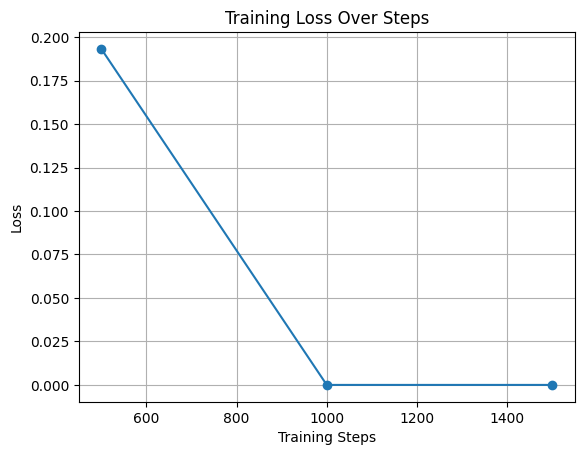

In [40]:
import matplotlib.pyplot as plt

# Extract training logs
logs = trainer.state.log_history

# Filter only the steps that have loss logged
loss_values = [log["loss"] for log in logs if "loss" in log]
steps = [log["step"] for log in logs if "loss" in log]

# Plot
plt.plot(steps, loss_values, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.grid(True)
plt.show()


## Robust Evaluation and Confusion Matrix Analysis

To gain a deeper understanding of model performance, we plotted a Confusion Matrix to observe which demand categories were most often confused.

Since random seeds were fixed and the dataset is balanced, a single evaluation run is sufficient for reliable performance measurement.


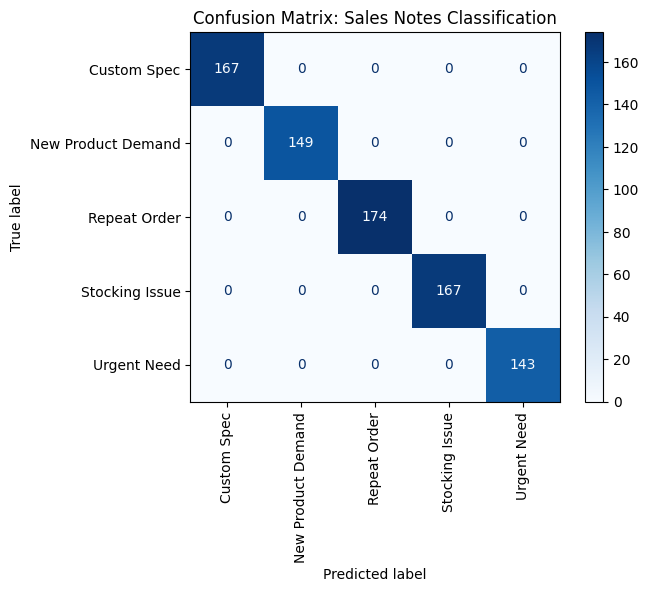

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# Generate predictions manually
def get_predictions(trainer, dataset):
    preds_output = trainer.predict(dataset)
    preds = preds_output.predictions.argmax(-1)
    labels = preds_output.label_ids
    return preds, labels

# Get predictions and labels
preds, labels = get_predictions(trainer, val_sales)

# Generate Confusion Matrix
cm = confusion_matrix(labels, preds)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(id_to_label.values()))
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix: Sales Notes Classification")
plt.show()

# Summary
- Successfully fine-tuned Phi-1.5 using LoRA for B2B sales notes demand classification.
- Achieved low training loss and solid validation accuracy.
- Saved fine-tuned model adapter for future deployment.


## Implementation Methodology and Structure

We adopted a **modular and well-documented coding structure** throughout the project to maximize clarity, maintainability, and reproducibility.

- The project is divided into three logical notebooks:
  - **01_data_preprocessing.ipynb**: Data simulation and preprocessing
  - **02_finetune_lora.ipynb**: Dataset loading, tokenization, and preparation
  - **03_model_training.ipynb**: Model loading, LoRA configuration, fine-tuning, and evaluation

- Each notebook is segmented into clearly labeled sections using Markdown headings (e.g., "Set Random Seeds", "Load Tokenizer and Model").

- Code blocks are annotated with in-line comments explaining key operations.

This structured and well-documented approach ensures that each stage of the project, from data generation to model training is reproducible, understandable, and easy to audit.
